In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import pickle
from tqdm import tqdm
from itertools import permutations
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from batchgen import TripletGenerator

/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def visualize_scatter(data_2d, label_ids, label_index = None, figsize=(20,20), nb_classes = 10):
    plt.figure(figsize=figsize)
    plt.grid()
    
    classes, counts = np.unique(label_ids, return_counts = True)
    idx = np.argsort(counts)[::-1][:nb_classes]
    classes = classes[idx]
    counts = counts[idx]
    for i, label_id in enumerate(classes):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(i),
                    linewidth='1',
                    alpha=0.8,
                    label=(label_index[label_id] if label_index else label_id))
    plt.legend(loc='best')

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [25]:
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)

In [26]:
x_train.shape

(60000, 28, 28, 1)

In [27]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

In [28]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])

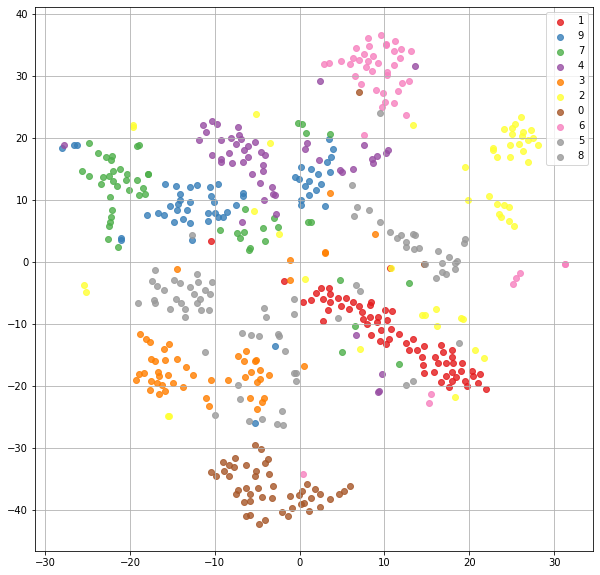

In [29]:
visualize_scatter(train_tsne_embeds, y_train[:512], figsize = (10, 10))

In [38]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in tqdm(sorted(set(data_xy[1]))):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [39]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)

100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


In [31]:
# Define triplet generators
tripletgen_train = TripletGenerator(x_train, 
                                     y_train,
                                     ap_pairs = 150, 
                                     an_pairs = 150, 
                                     batch_size = 64,
                                     shuffle = True, 
                                     renew = True)

tripletgen_test = TripletGenerator(x_test,
                                    y_test,
                                    ap_pairs = 30,
                                    an_pairs = 30,
                                    batch_size = 64,
                                    shuffle = False,
                                    renew = False)

In [32]:
len(tripletgen_train.triplet_index), len(tripletgen_test.triplet_index)

(225000, 9000)

In [33]:
def triplet_cosine_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    # print('y_pred.shape = ',y_pred)
    cosine_loss = tf.keras.losses.CosineSimilarity(axis = 1)    
    total_lenght = y_pred.shape.as_list()[-1]
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # positive loss
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    pos_loss = 1 - K.abs(cosine_loss(anchor, positive))

    # negative loss
    neg_loss = K.abs(cosine_loss(anchor, negative))

    # compute loss
    loss = pos_loss + neg_loss
 
    return loss

In [56]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [57]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_cosine_loss, optimizer=adam_optim)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4)            876036      anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [58]:
Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=64, epochs=500)

Train on 180000 samples, validate on 45000 samples
Epoch 1/500
180000/180000 [==============================] - 88s 490us/sample - loss: 0.1040 - val_loss: 0.2716
Epoch 2/500
  4032/180000 [..............................] - ETA: 1:15 - loss: 0.0594

KeyboardInterrupt: 

In [62]:
model.fit_generator(
    tripletgen_train,
    steps_per_epoch = 2810,
    validation_data=tripletgen_test, 
    validation_steps = 200,
    max_queue_size = 20000,
    use_multiprocessing = True,
    workers = 8,
    epochs=50, 
    verbose = 1)

Epoch 1/50
 310/2810 [==>...........................] - ETA: 2:06 - loss: 0.0447

Process Keras_worker_ForkPoolWorker-84:
Process Keras_worker_ForkPoolWorker-92:
Process Keras_worker_ForkPoolWorker-86:
Process Keras_worker_ForkPoolWorker-91:
Process Keras_worker_ForkPoolWorker-85:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-96:
Process Keras_worker_ForkPoolWorker-87:
Process Keras_worker_ForkPoolWorker-95:
Process Keras_worker_ForkPoolWorker-88:
Process Keras_worker_ForkPoolWorker-94:
Process Keras_worker_ForkPoolWorker-83:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-97:
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process Keras_worker_ForkPoolWorker-90:
Traceback (most recent call last):
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

Process Keras_worker_ForkPoolWorker-82:
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/yoelm

KeyboardInterrupt: 

  File "/home/yoelmolinas/.conda/envs/gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [48]:
model.save_weights("progress/triplet_model_MNIST.hdf5")

In [50]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('progress/triplet_model_MNIST.hdf5')

In [51]:
tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

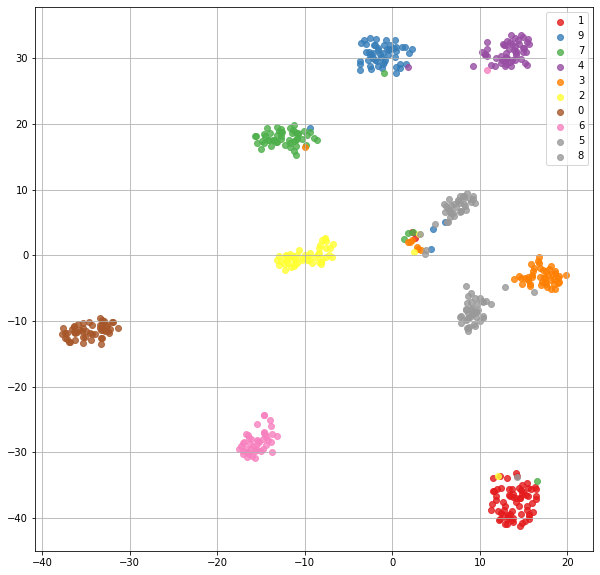

In [52]:
visualize_scatter(train_tsne_embeds, y_train[:512], figsize = (10, 10))

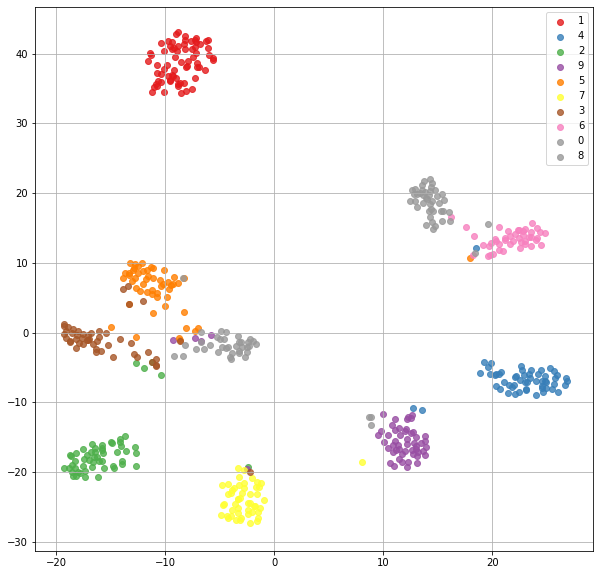

In [53]:
visualize_scatter(eval_tsne_embeds, y_test[:512], figsize = (10, 10))